https://www.kaggle.com/yiidtw/a-complete-guide-for-regression-problem/data
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import binned_statistic
import statistics as sta
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [117]:
# import data
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

train = pd.read_csv("P:/KaggleProject/House/train.csv")
test = pd.read_csv("P:/KaggleProject/House/test.csv")

In [118]:
train.shape

(1460, 81)

In [119]:
test.shape

(1459, 80)

In [120]:
# take a look at target:SalePrice
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [179]:
# check which variable in training but not in testing, hopefully only target
train_columns = list(train.columns.values)
test_columns = list(test.columns.values)
set(train_columns) - set(test_columns)

{'HasBsmt', 'SalePrice'}

Let's analyse this to understand how to handle missing data.

Generally speaking, if the missing rate is >= 15%, we will consider to delete it. But it doesn't mean those are not important. Before deleting it, we should take a look and decide there is no business importance as well. 


,Missing_Percent,Missing_Count
PoolQC,0.995205,1453
MiscFeature,0.963014,1406
Alley,0.937671,1369
Fence,0.807534,1179
FireplaceQu,0.472603,690
LotFrontage,0.177397,259
GarageFinish,0.055479,81
GarageQual,0.055479,81
GarageType,0.055479,81
GarageYrBlt,0.055479,81


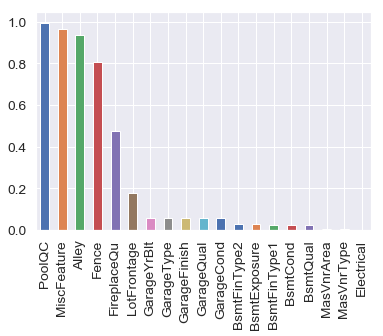

In [121]:
# calculate missing percentage of training data, sort decending(series)
Null_train = train.isnull().sum()[train.isnull().sum().values >0]
Null_train_P = Null_train/train.shape[0]
# decending sort series and performance operation in-place(inplace=True)
Null_train_P.sort_values(ascending=False,inplace=True)
Null_train_P.plot.bar()

Null_Data = pd.concat([Null_train_P,Null_train],axis=1)
Null_Data.columns =['Missing_Percent','Missing_Count']
Null_Data.sort_values(by=['Missing_Percent'],ascending=False)

In [122]:
# In 'Electrical' we'll just delete the observation with missing data.
# default, df.drop is to drop rows
# df.drop, axis=1 is to drop columns

# ind is the row need to drop
ind = train[train['Electrical'].isnull()].index.tolist()
train.drop(ind,inplace=True)
train['Electrical'].isnull().sum()

test['Electrical'].isnull().sum()

0

In [123]:
# This is just exercise: for PoolQC, if it is null then 0 else 0
print(train['PoolQC'].isnull().sum())

# to detect if a number is null or not use pd.isnull(x)
train['PoolQC_indicator'] = train['PoolQC'].apply(lambda x: 0 if pd.isnull(x) else 1)
train['PoolQC_indicator'].value_counts()

test['PoolQC_indicator'] = test['PoolQC'].apply(lambda x: 0 if pd.isnull(x) else 1)
test['PoolQC_indicator'].value_counts()

1452


0    1456
1       3
Name: PoolQC_indicator, dtype: int64

Normality: Check univariate normality for SalePrice

For sample > 200, normality is not a big issue

For probplt, data distribution should closely follow the diagnol to make sure it is a normal distribution.
However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity). 
in case of positive skewness, log transformations usually works well

In [124]:
#skewness tell how skewed the data is. Normal distribution has skew as 0
#Kurtosis tell how shape the distribution it is. Normal distribution has skew as 3
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())
# Skewness >0 means positive skewed


Skewness: 1.881943
Kurtosis: 6.529263


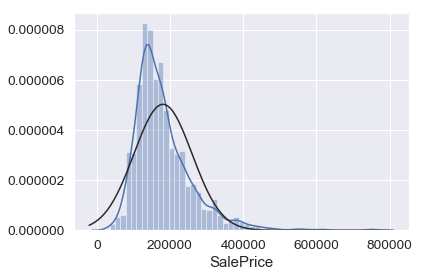

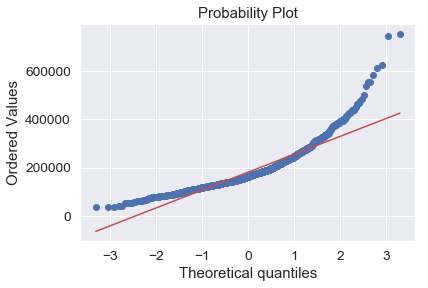

In [125]:
# look at target distribution 
# from the plot, you can see it deviates from normal distribution(if we use OLS may not very good, since target don't follow normal distribution) 
sns.distplot(train['SalePrice'],fit=norm);
fig = plt.figure()

res = stats.probplot(train['SalePrice'],plot=plt)

skewness and kurtosis
https://zhuanlan.zhihu.com/p/27711561

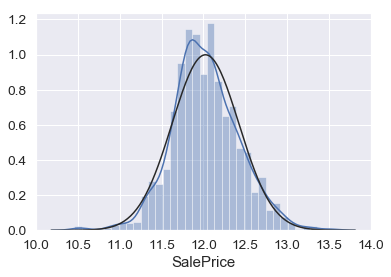

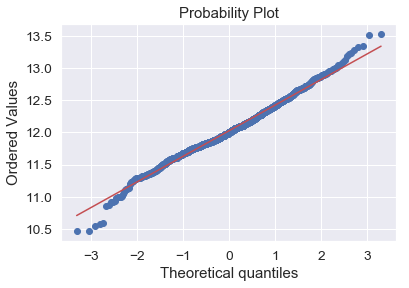

In [126]:
#applying log transformation
SalePrice_log = np.log(train['SalePrice'])


#transformed histogram and normal probability plot
sns.distplot(SalePrice_log, fit=norm);
fig = plt.figure()
res = stats.probplot(SalePrice_log, plot=plt)

Ok, now we are dealing with the big boss. What do we have here?

Something that, in general, presents skewness.
A significant number of observations with value zero (houses without basement).
A big problem because the value zero doesn't allow us to do log transformations.
To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

I'm not sure if this approach is correct. It just seemed right to me. That's what I call 'high risk engineering'.

In [127]:
# create binary variable has discount or not
train['HasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 0 if x==0 else 1)
train['HasBsmt'].value_counts()

1    1422
0      37
Name: HasBsmt, dtype: int64

In [128]:
# transform data for HasBsmt == 1
# train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])
# train.loc[train['HasBsmt']==1,'TotalBsmtSF'][0:5]

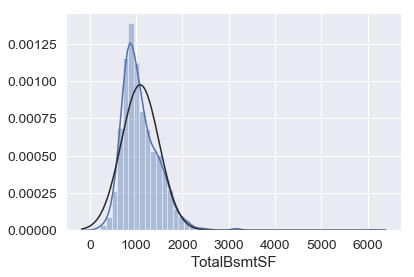

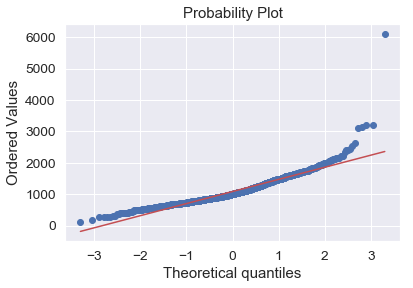

In [129]:
# plot histogram and normal probability plot
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'],fit=norm)
fit= plt.figure()
res = stats.probplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

Homoscedasticity 
Homoscedasticity means dependent variable shows equal variance across all the values of predictor variables.
Homoscedasticity is desirable since we want to error term to be the same across all the values of the independent variables

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

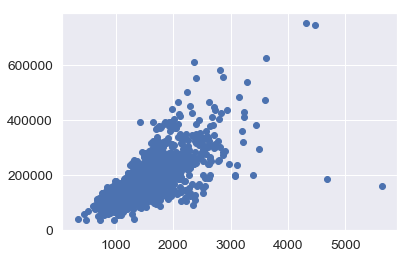

In [130]:
#scatter plot
#At lower end, the data has small dispension and upper end has high dispension which means homoscedasticity maybe a problem
plt.scatter(train['GrLivArea'], train['SalePrice']);

Relationship with numeric variables

We can tell SalePrice and GrLivArea has linear relationship

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


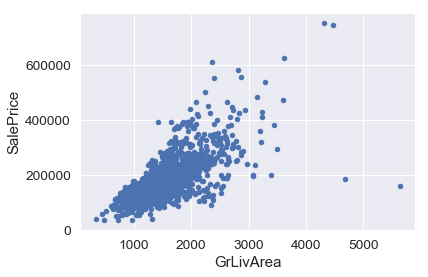

In [131]:
var = 'GrLivArea'
data=pd.concat([train['SalePrice'],train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice')

Relationship with categorical features
https://zhuanlan.zhihu.com/p/51410048

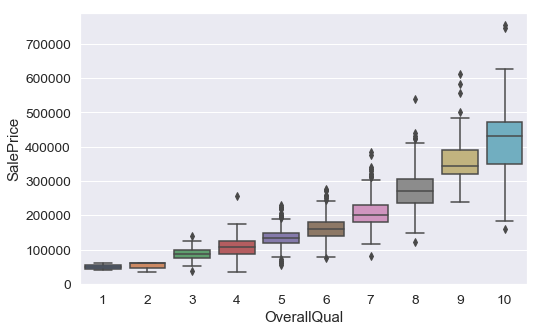

In [132]:
# box plot of overallqual vs. saleprice
# As OverallQual gets larger, the SalePrice gets larger as well
var = 'OverallQual'
data = pd.concat([train['SalePrice'],train[var]],axis=1)
f, ax = plt.subplots(figsize=(8,5))
fig = sns.boxplot(x=var,y='SalePrice',data=data)
# fig.axis(ymin=0,ymax=800000)

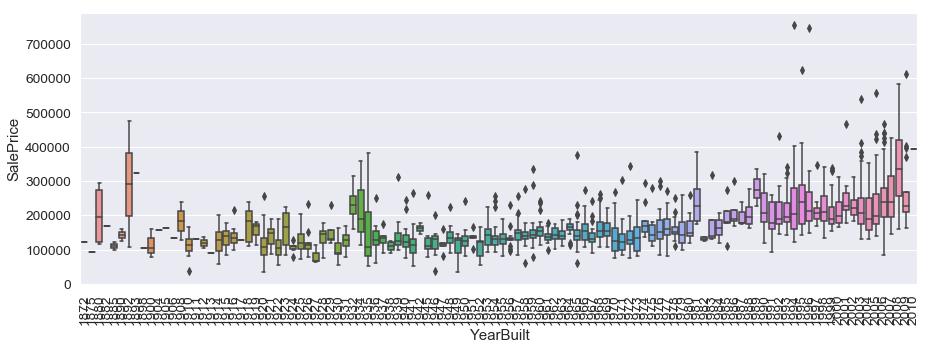

In [133]:
# box plot of yearbuild vs saleprice
# Here, we can see that we spend more money on new house more than old one
# But some old house is still valuable, typically in SF, even house in 1920 still worthy 1.5 million 
var = 'YearBuilt'
data = pd.concat([train[var],train['SalePrice']],axis=1)
f, ax= plt.subplots(figsize=(15,5))
fig = sns.boxplot(x=var,y='SalePrice',data=data)
# fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

In Summary 
1. 'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
2. 'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

Here, let's focus more on feature selection

Heatmap can give a quick overview of the relationship between each variables

The color is more lighter means more positive related. Much more darker means much more negative related
'TotalBsmtSF' and '1stFlrSF' variables are highly positive correlated. Actually, this correlation is so strong that it indicates multicollinearity. We can conclude that they give almost the same information, so multicollearity really occurs.

Heatmap is essential tool to detect this kind of situation

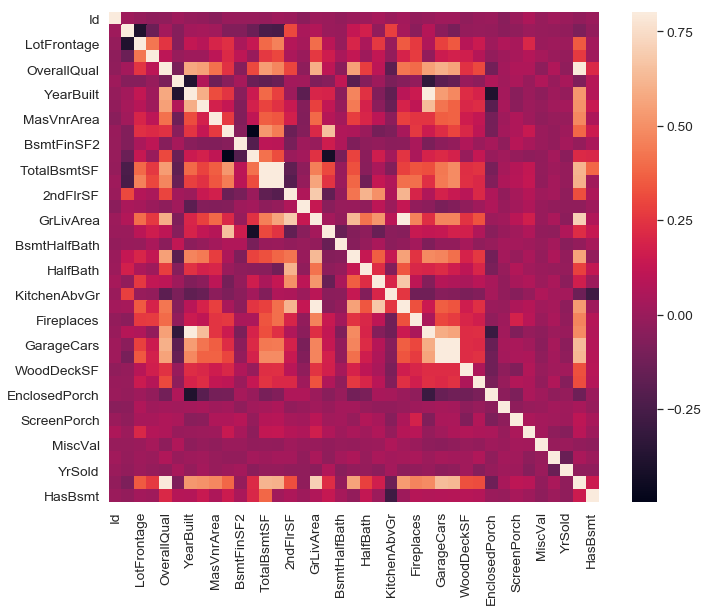

In [134]:
# visualize correlation matrix
train.drop(columns=['PoolQC_indicator'],inplace=True)
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Another thing got my attention is the Sales prices. We can see that 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' all has strong correlation with SalePrice and let's look at other variables as well

In [135]:
# find features has positive correlation with target
corr_target=train.corr()['SalePrice']
corr_target_positive = corr_target[corr_target>0].sort_values(ascending=False).index.tolist()

# there are 28 features has positive relationship with target
print("There are %d features(include itself) have positive correlation with target." % len(corr_target_positive))
corr_target[corr_target>0].sort_values(ascending=False)

There are 29 features(include itself) have positive correlation with target.


SalePrice       1.000000
OverallQual     0.791069
GrLivArea       0.708618
GarageCars      0.640473
GarageArea      0.623423
TotalBsmtSF     0.613905
1stFlrSF        0.605968
FullBath        0.560881
TotRmsAbvGrd    0.533779
YearBuilt       0.523273
YearRemodAdd    0.507430
GarageYrBlt     0.486797
MasVnrArea      0.477486
Fireplaces      0.466968
BsmtFinSF1      0.386436
LotFrontage     0.351821
WoodDeckSF      0.324422
2ndFlrSF        0.319464
OpenPorchSF     0.315831
HalfBath        0.284400
LotArea         0.263837
BsmtFullBath    0.227082
BsmtUnfSF       0.214446
BedroomAbvGr    0.168235
HasBsmt         0.152851
ScreenPorch     0.111419
PoolArea        0.092397
MoSold          0.046380
3SsnPorch       0.044571
Name: SalePrice, dtype: float64

In [136]:
# add data types to correlation data
corr_train_pos_data = pd.DataFrame(corr_target[corr_target>0].sort_values(ascending=False))

# change column name to 'DataType'
corr_train_pos_data.columns=['Correlation']
train_data_type = pd.DataFrame(train.dtypes,columns=['DataType'])

In [137]:
# combine columns together
corr_train_pos_datatype = pd.merge(train_data_type,corr_train_pos_data,how='inner',left_index=True,right_index=True)
corr_train_pos_datatype.sort_values(by=['Correlation'],ascending=False,inplace=True)
corr_train_pos_datatype

,DataType,Correlation
SalePrice,int64,1.000000
OverallQual,int64,0.791069
GrLivArea,int64,0.708618
GarageCars,int64,0.640473
GarageArea,int64,0.623423
TotalBsmtSF,int64,0.613905
1stFlrSF,int64,0.605968
FullBath,int64,0.560881
TotRmsAbvGrd,int64,0.533779
YearBuilt,int64,0.523273


In [138]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [139]:
# get the correlation coefficient
cm= np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
cm

array([[1.        , 0.79106866, 0.70861761, 0.6404729 , 0.6234229 ,
        0.61390497, 0.60596786, 0.56088062, 0.53377887, 0.52327306],
       [0.79106866, 1.        , 0.59302078, 0.60099085, 0.5619799 ,
        0.53752254, 0.47593305, 0.55126739, 0.42771967, 0.57333396],
       [0.70861761, 0.59302078, 1.        , 0.46732095, 0.46897069,
        0.45500099, 0.5660837 , 0.63028308, 0.82557645, 0.19928607],
       [0.6404729 , 0.60099085, 0.46732095, 1.        , 0.88261303,
        0.43527928, 0.43972587, 0.46961933, 0.36224816, 0.53786619],
       [0.6234229 , 0.5619799 , 0.46897069, 0.88261303, 1.        ,
        0.48671898, 0.48974143, 0.40594403, 0.33791527, 0.47945968],
       [0.61390497, 0.53752254, 0.45500099, 0.43527928, 0.48671898,
        1.        , 0.81939327, 0.32488563, 0.28612483, 0.39315875],
       [0.60596786, 0.47593305, 0.5660837 , 0.43972587, 0.48974143,
        0.81939327, 1.        , 0.38143752, 0.4099005 , 0.28305637],
       [0.56088062, 0.55126739, 0.6302830

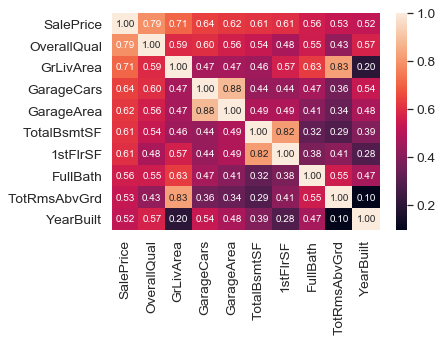

In [140]:
# xticklabels or yticklabels=cols.values(add x and y axis labels, such as SalesPrice, OverallQual, original only has number 1,2,3 ...)
# annot=True shows correlation coefficient in cells
# fmt='.2f' limit to 2 digits
# annot_kws={'size': 10} adjust the nummber size
hm = sns.heatmap(cm,xticklabels=cols.values,
                yticklabels=cols.values,
                annot=True,
                fmt='.2f', 
                annot_kws={'size': 10})
plt.show()

(Summary as above)
According to our crystal ball, these are the variables most correlated with 'SalePrice'. My thoughts on this:

1.'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Check!

2.'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).

3.'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF' just to say that our first guess was right (re-read 'So... What can we expect?').

4.'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. Is this dataset from Chernobyl?
Ah... 'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'. Honestly, it scares me to think about 'YearBuilt' because I start feeling that we should do a little bit of time-series analysis to get this right.

I'll only pick a few to further demonstrate feature engineering techniques, at most 10 candidates. After look it up in the data description, here's how I pick

1. OverallQual for sure, since its high correlation, and the delegate of categorized data [1-10]
2. GrLivArea, also because its high correlation and delegate of numerical data
3. I'll pick GarageCars rather than GarageArea, it's somehow like binned
4. I've noticed that there are TotalBsmtSF, 1stFlrSF, and 2ndFlrSF, they seem like related to GrLivArea, they're all about the area in the house, I'll do the feature cross techniques with it
5. I'll pick MasVnrArea although there're a few(8) null values in it, we can fill with mean or something else reasonable
6. I'll pick Fireplaces for another categorized example, since it sounds like a luxuriness indicator

Here're why I don't pick
1. I'll drop TotRmsAbvGrd since it looks like highly related to GrLivArea, same applies on GarageCars and GarageArea cases
2. I'd rather not pick those time series related for simplicity

So, we have 8 feature candidates now.

In [142]:
# After feature selection, make the final training data
idx_meta = ['SalePrice','GrLivArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'Fireplaces', 'GarageCars','YearBuilt']
train_meta = train[idx_meta ].copy()
print(train_meta.head())


   SalePrice  GrLivArea  MasVnrArea  TotalBsmtSF  1stFlrSF  2ndFlrSF  \
0     208500       1710       196.0          856       856       854   
1     181500       1262         0.0         1262      1262         0   
2     223500       1786       162.0          920       920       866   
3     140000       1717         0.0          756       961       756   
4     250000       2198       350.0         1145      1145      1053   

   OverallQual  Fireplaces  GarageCars  YearBuilt  
0            7           0           2       2003  
1            6           1           2       1976  
2            7           1           2       2001  
3            7           1           3       1915  
4            8           1           3       2000  


In [143]:
# find null values for those features. Only MasVnrArea has 8 missing values
train_meta.isnull().sum()

SalePrice      0
GrLivArea      0
MasVnrArea     8
TotalBsmtSF    0
1stFlrSF       0
2ndFlrSF       0
OverallQual    0
Fireplaces     0
GarageCars     0
YearBuilt      0
dtype: int64

In [144]:
# look at MasVnrArea distribution 
MasVnrArea_mode = sta.mode(train_meta['MasVnrArea'])

# replace null in train_meta as mode
train_meta['MasVnrArea'][train_meta['MasVnrArea'].isnull()] = MasVnrArea_mode

# after impute null values, how many are still null
print("How many null values remaining? %d" % train_meta['MasVnrArea'].isnull().sum())

How many null values remaining? 0


pairplot show scatter plot for two variables plot and histogram plot for univariate variable

histogram is a bar plot of numeric data that group data in different bins

The relationship between 'SalePrice' and 'YearBuilt' looks like exponential function 


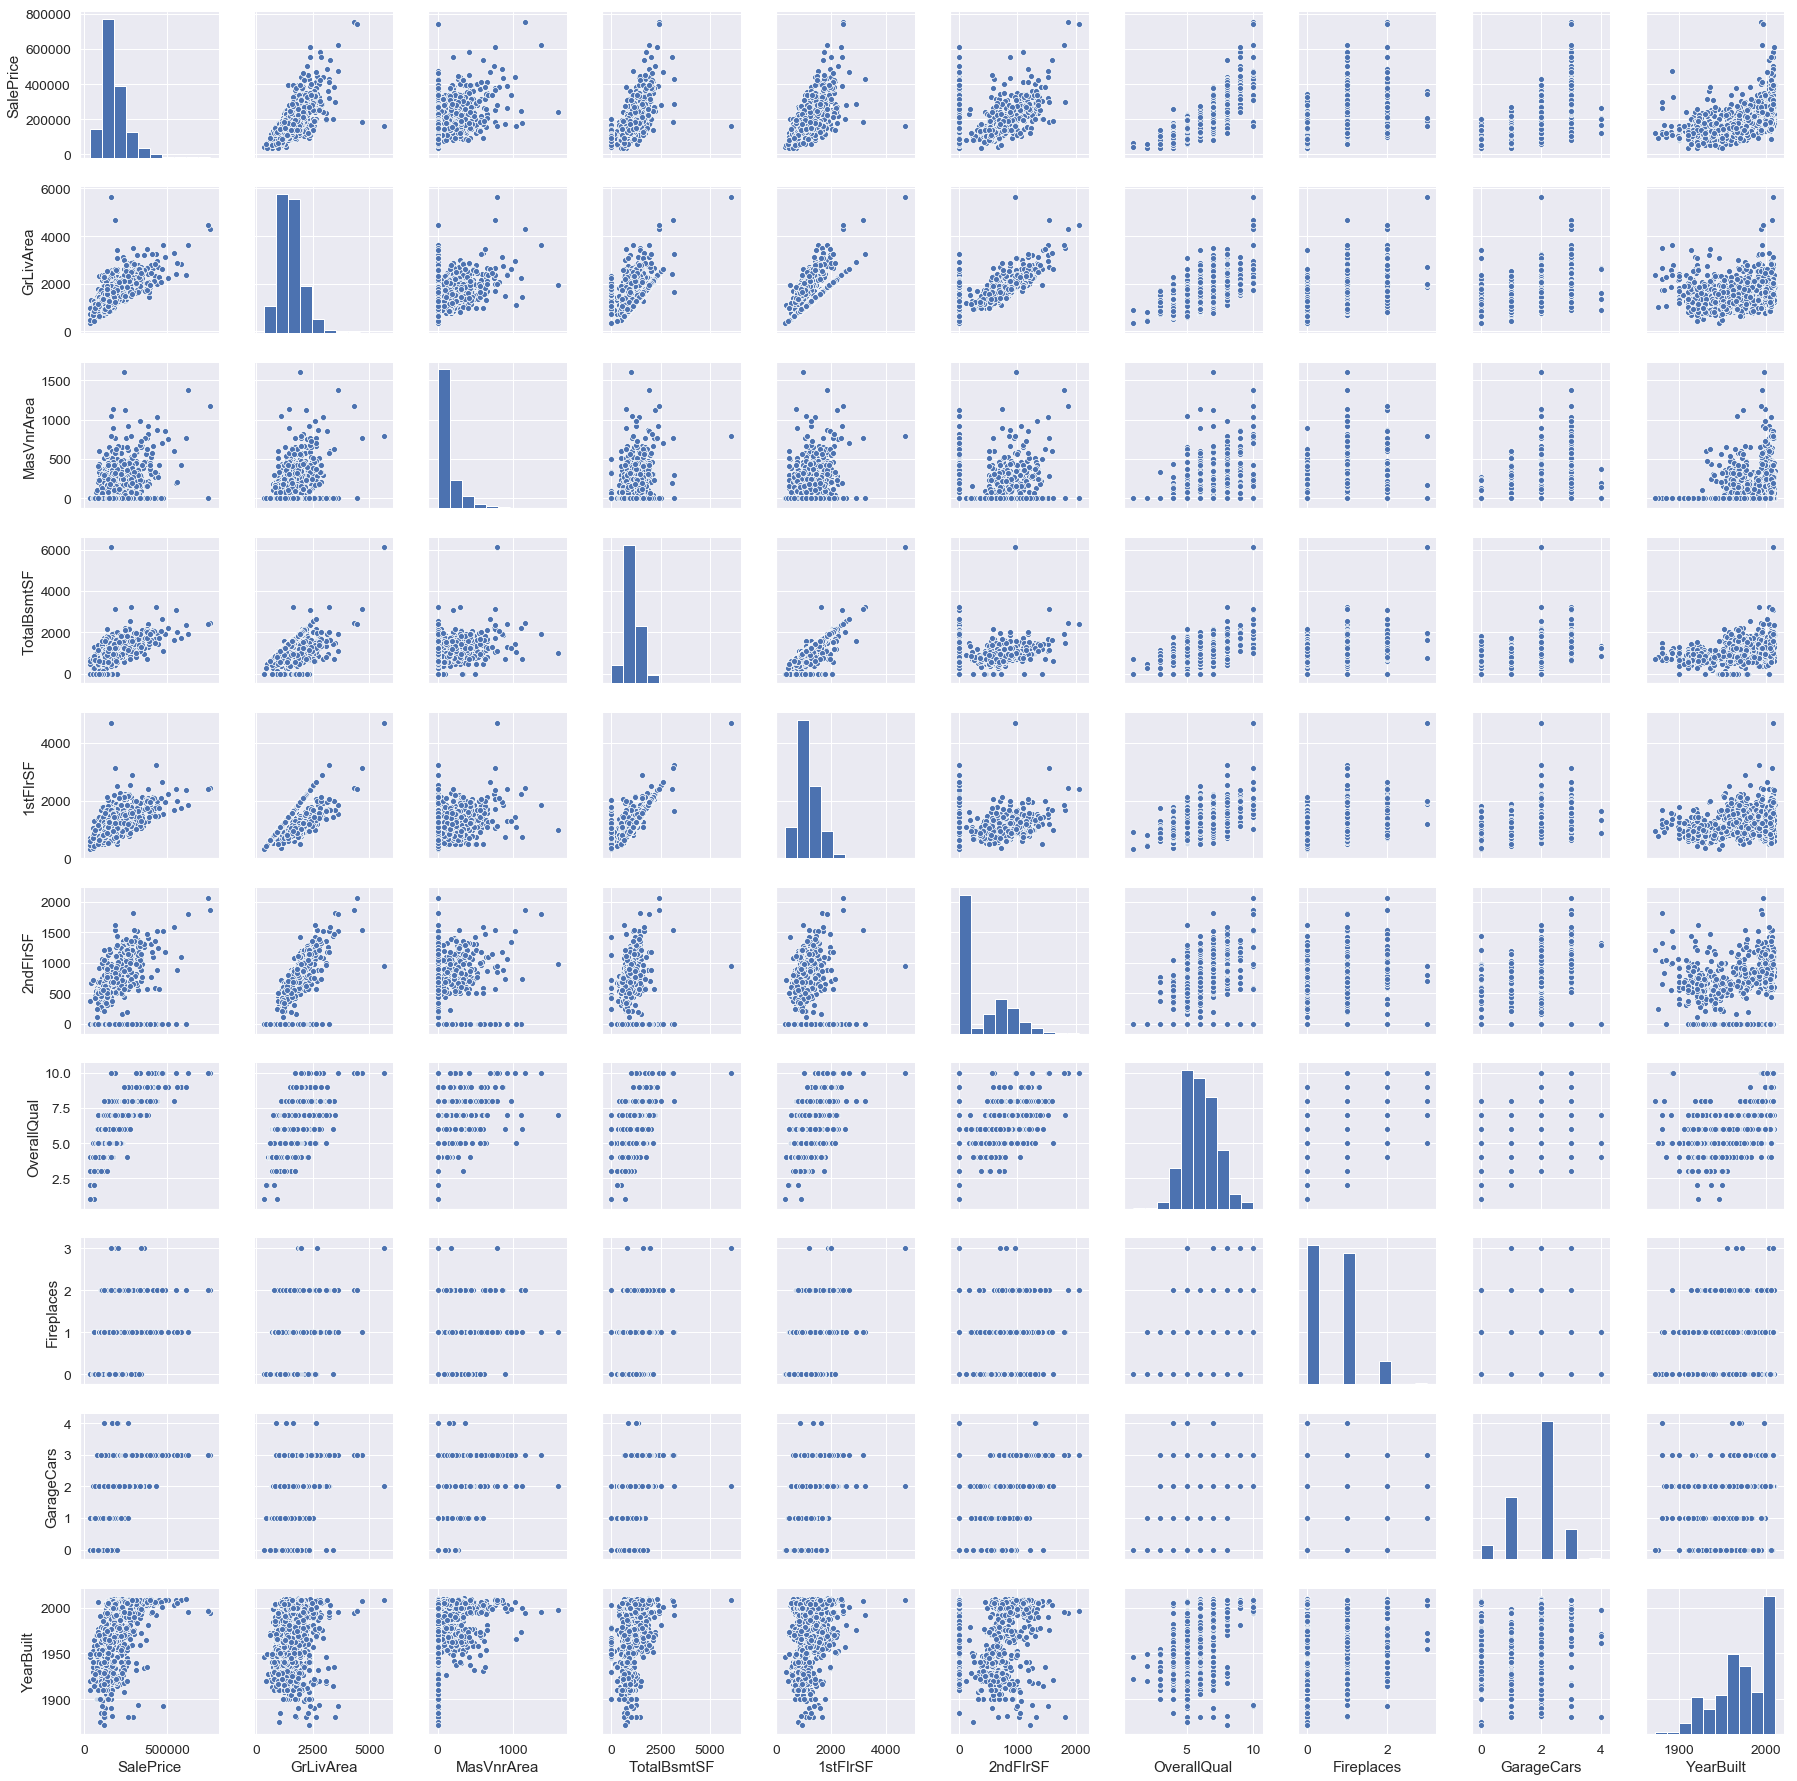

In [145]:
sns.pairplot(train_meta)

In [146]:
# find outlier, could remove not remove
train_meta[(train_meta['GrLivArea'] > 4000) &(train_meta['SalePrice'] > 200000)].index.tolist()

[691, 1182]

In [147]:
# drop the 3 points. 1 is used for testing
train_meta = train_meta.drop([1,691, 1182])

In [148]:
train_meta.head()

,SalePrice,GrLivArea,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,OverallQual,Fireplaces,GarageCars,YearBuilt
0,208500,1710,196.0,856,856,854,7,0,2,2003
2,223500,1786,162.0,920,920,866,7,1,2,2001
3,140000,1717,0.0,756,961,756,7,1,3,1915
4,250000,2198,350.0,1145,1145,1053,8,1,3,2000
5,143000,1362,0.0,796,796,566,5,0,2,1993


In [149]:
# iloc is the position, loc is the real index
train_meta.iloc[1,:]

SalePrice      223500.0
GrLivArea        1786.0
MasVnrArea        162.0
TotalBsmtSF       920.0
1stFlrSF          920.0
2ndFlrSF          866.0
OverallQual         7.0
Fireplaces          1.0
GarageCars          2.0
YearBuilt        2001.0
Name: 2, dtype: float64

In [150]:
# since 0 has almost take 50%. Make another features call has_MasVnrArea or not
train_meta['MasVnrArea'].value_counts()

# method1:create def function
def create_new(var):
    if var == 0:
        return 0
    else:
        return 1

train_meta['has_MasVnrArea'] = train_meta['MasVnrArea'].apply(create_new)

# method2: use lambda 
train_meta['has_MasVnrArea2'] = train_meta['MasVnrArea'].apply(lambda x: 0 if x ==0 else 1)

In [151]:
print(train_meta['has_MasVnrArea'].value_counts())
print(train_meta['has_MasVnrArea2'].value_counts())

0    866
1    590
Name: has_MasVnrArea, dtype: int64
0    866
1    590
Name: has_MasVnrArea2, dtype: int64


In [152]:
# drop few variables
train_meta.drop(columns=['has_MasVnrArea2','MasVnrArea'],inplace=True)
train_meta.columns

Index(['SalePrice', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'OverallQual', 'Fireplaces', 'GarageCars', 'YearBuilt',
       'has_MasVnrArea'],
      dtype='object')

In [153]:
# separate data to numeric and categorical
train_meta.head()

,SalePrice,GrLivArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,OverallQual,Fireplaces,GarageCars,YearBuilt,has_MasVnrArea
0,208500,1710,856,856,854,7,0,2,2003,1
2,223500,1786,920,920,866,7,1,2,2001,1
3,140000,1717,756,961,756,7,1,3,1915,0
4,250000,2198,1145,1145,1053,8,1,3,2000,1
5,143000,1362,796,796,566,5,0,2,1993,0


In [154]:
Num_data = train_meta.drop(columns=['OverallQual','Fireplaces','GarageCars','has_MasVnrArea'])
Cat_data = train_meta[['OverallQual','Fireplaces','GarageCars','has_MasVnrArea']]

# change to categorical before use pd.get_dummies
Cat_data['OverallQual'] = Cat_data['OverallQual'].astype(str)
Cat_data['Fireplaces'] = Cat_data['Fireplaces'].astype(str)
Cat_data['GarageCars'] = Cat_data['GarageCars'].astype(str)
Cat_data['has_MasVnrArea'] = Cat_data['has_MasVnrArea'].astype(str)
Cat_data.dtypes

# apply pd.get_dummies after data is changed to categorical
Cat_data_dum = pd.get_dummies(Cat_data)
Cat_data_dum.head()

,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,...,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,has_MasVnrArea_0,has_MasVnrArea_1
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [155]:
# combine numeric data and categorical data together 
train_data = pd.merge(Num_data,Cat_data_dum,left_index=True, right_index=True, how='inner')
train_data.head()

,SalePrice,GrLivArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,YearBuilt,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,...,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,has_MasVnrArea_0,has_MasVnrArea_1
0,208500,1710,856,856,854,2003,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,223500,1786,920,920,866,2001,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,140000,1717,756,961,756,1915,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
4,250000,2198,1145,1145,1053,2000,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
5,143000,1362,796,796,566,1993,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


Model process

In [157]:
from sklearn.model_selection import train_test_split
random_state = 7

x_train = train_data.drop(columns=['SalePrice'])
y_train = train_data['SalePrice']

print(x_train.head())
y_train.head()
# x_train2 = train_data.drop(columns=['SalePrice','SalePrice_log'])
# y_train2 = train_data['SalePrice_log']

   GrLivArea  TotalBsmtSF  1stFlrSF  2ndFlrSF  YearBuilt  OverallQual_1  \
0       1710          856       856       854       2003              0   
2       1786          920       920       866       2001              0   
3       1717          756       961       756       1915              0   
4       2198         1145      1145      1053       2000              0   
5       1362          796       796       566       1993              0   

   OverallQual_10  OverallQual_2  OverallQual_3  OverallQual_4  \
0               0              0              0              0   
2               0              0              0              0   
3               0              0              0              0   
4               0              0              0              0   
5               0              0              0              0   

         ...         Fireplaces_1  Fireplaces_2  Fireplaces_3  GarageCars_0  \
0        ...                    0             0             0            

0    208500
2    223500
3    140000
4    250000
5    143000
Name: SalePrice, dtype: int64

In [158]:
# separate training data to training and validation 
x_train_test, x_valid, y_train_test, y_valid = train_test_split(x_train,
                                                            y_train,
                                                            test_size=0.2,
                                                            random_state=random_state)

x_train, x_test, y_train, y_test = train_test_split(x_train_test,
                                                   y_train_test,
                                                   test_size=0.2,
                                                   random_state = random_state)

In [159]:
# separate data to training, validation and testing
# x_train_test2, x_valid2, y_train_test2, y_valid2 = train_test_split(x_train2,
#                                                             y_train2,
#                                                             test_size=0.2,
#                                                             random_state=random_state)

# x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train_test2,
#                                                    y_train_test2,
#                                                    test_size=0.2,
#                                                    random_state = random_state)

In [160]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# print(x_train2.shape)
# print(x_test2.shape)
# print(y_train2.shape)
# print(y_test2.shape)

(931, 26)
(233, 26)
(931,)
(233,)


In [161]:
# get root mean square error
def rmse(var1,var2):
    return np.sqrt(np.mean((var1-var2)**2))

In [162]:
# fit Ordinary least square linear regression(OLS)
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
# lm2 = LinearRegression()

lm.fit(x_train,y_train)
# lm2.fit(x_train2,y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [163]:
# predict 
y_test_pred = lm.predict(x_test)
# y_test_pred2 = lm2.predict(x_test2)
# y_test_pred2 = np.exp(y_test_pred2)

In [164]:
rmse_linear = rmse(y_test, y_test_pred)
rmse_linear

# rmse_linear2 = rmse(y_test2, y_test_pred2)
# print(rmse_linear2)



38154.36978428354

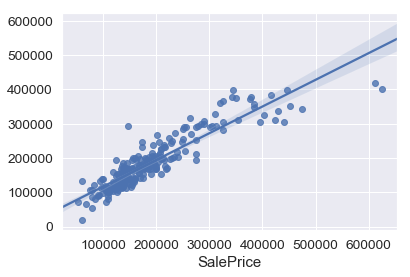

In [165]:
sns.regplot(y_test, y_test_pred)

Random Forest Model(Regression tree: after tree split, the output is the numeric target instead of classes) 

It looks as if everything is in order! Just to recap, to get the data into a form acceptable for machine learning we:

1. One-hot encoded categorical variables
2. Split data into features and labels
3. Converted to arrays
4. Split data into training and testing sets

Depending on the initial data set, there may be extra work involved such as removing outliers,
imputing missing values

In [167]:
y_train_rf = np.array(y_train)
y_test_rf = np.array(y_test)

feature_list = list(x_train.columns)
# Convert to numpy array
x_train_rf = np.array(x_train)
x_test_rf = np.array(x_test)

In [181]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
# n_estimators: number of trees
# max_depth refers to the maximum depth of the tree 
rf = RandomForestRegressor(n_estimators = 1000, max_features='sqrt',random_state = 42)

# Train the model on training data
rf.fit(x_train_rf, y_train_rf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [182]:
# Use the forest's predict method on the test data
y_test_rf_pred = rf.predict(x_test_rf)

In [183]:
rmse(y_test_rf_pred,y_test_rf)

36830.00222993032

In [184]:
# calculate mean absolute error percentage to measure the performance metrics
errors = abs(y_test_rf_pred - y_test_rf)
mape = 100 * (errors / y_test_rf)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 87.73 %.


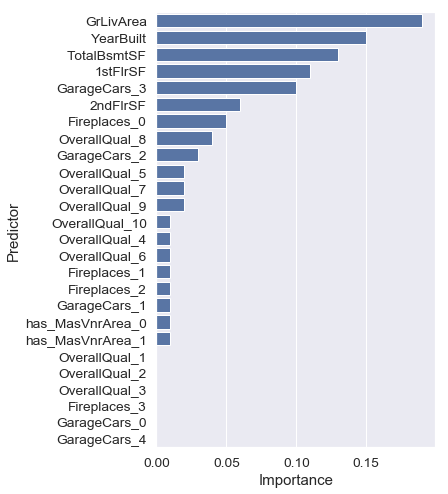

In [193]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
importances

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances

# make list as dataframe
feature_importances_df = pd.DataFrame.from_records(feature_importances,columns=['Predictor','Importance'])
feature_importances_df

f, ax = plt.subplots(figsize=(5,8))
sns.barplot(x="Importance", y="Predictor", data=feature_importances_df,
            label="Importance", color="b")


In [194]:
# xgboost: https://www.datacamp.com/community/tutorials/xgboost-in-python
import xgboost as xgb
from xgboost import plot_importance

# convert data to matrix



[20:36:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[20:36:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[20:36:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[20:36:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[20:36:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[20:36:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[20:36:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

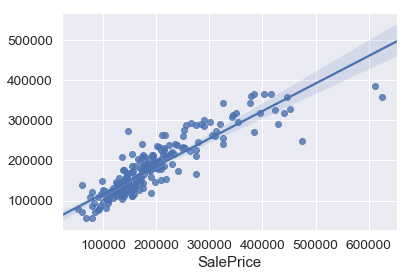

In [203]:
params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'n_estimator':100,
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

plst = params.items()
dtrain = xgb.DMatrix(data=x_train,label=y_train)
dtest = xgb.DMatrix(x_test)
# num_rounds = 500
xgb_model = xgb.train(plst, dtrain);
yt_xgb = xgb_model.predict(dtest);
yt_xgb
rmse_xgb = rmse(y_test, yt_xgb)
sns.regplot(y_test, yt_xgb)
print("RMSE for xgboost: %.2f" % rmse_xgb)

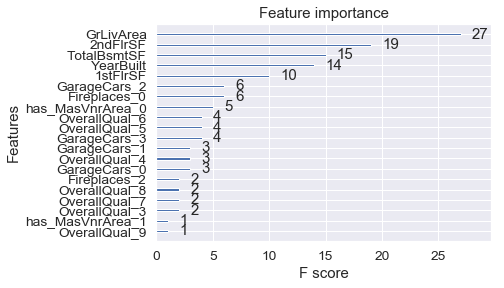

In [201]:
# get variable importance
plot_importance(xgb_model)